<a href="https://colab.research.google.com/github/ekity1002/pytorch_codes/blob/master/BERT_Japanese_Livedoor_news_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下準備
* ライブラリのインストール、データセットのダウンロード

In [ ]:
%%bash
wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
tar xvzf ldcc-20140209.tar.gz
apt install aptitude swig
aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y

pip install mecab-python3==0.996.5
#pip install mecab-python3
pip install unidic-lite nlplot japanize-matplotlib transformers fugashi ipadic

text/
text/CHANGES.txt
text/dokujo-tsushin/
text/it-life-hack/
text/kaden-channel/
text/livedoor-homme/
text/movie-enter/
text/peachy/
text/README.txt
text/smax/
text/sports-watch/
text/topic-news/
text/topic-news/LICENSE.txt
text/topic-news/topic-news-5903225.txt
text/topic-news/topic-news-5903373.txt
text/topic-news/topic-news-5907376.txt
text/topic-news/topic-news-5908396.txt
text/topic-news/topic-news-5910461.txt
text/topic-news/topic-news-5910462.txt
text/topic-news/topic-news-5911453.txt
text/topic-news/topic-news-5913367.txt
text/topic-news/topic-news-5913447.txt
text/topic-news/topic-news-5914835.txt
text/topic-news/topic-news-5918064.txt
text/topic-news/topic-news-5921231.txt
text/topic-news/topic-news-5927166.txt
text/topic-news/topic-news-5927208.txt
text/topic-news/topic-news-5927215.txt
text/topic-news/topic-news-5927968.txt
text/topic-news/topic-news-5928611.txt
text/topic-news/topic-news-5930156.txt
text/topic-news/topic-news-5930399.txt
text/topic-news/topic-news-593112

--2020-09-08 14:53:44--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 72.2K 1m59s
    50K .......... .......... .......... .......... ..........  1%  216K 79s
   100K .......... .......... .......... .......... ..........  1%  217K 65s
   150K .......... .......... .......... .......... ..........  2%  217K 58s
   200K .......... .......... .......... .......... ..........  2%  217K 54s
   250K .......... .......... .......... .......... ..........  3%  217K 51s
   300K .......... .......... .......... .......... ..........  4%  174M 44s
   350K .......... .......... .......... .......... ..........  4%  217K 43s
   400K .......... .......... 

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import nlplot
import warnings
warnings.simplefilter('ignore')    
import torch
import transformers
from transformers import BertJapaneseTokenizer
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR) # tokenize時の警告を抑制

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# データセット読み込み

In [ ]:
def load_dataset():
    paths = []
    for dirpath, dirnames, filenames in os.walk('./text'):
        for file in filenames:
            if re.match(r'.+[0-9].txt',  file):
                #print("{0}".format(file))
                paths.append(os.path.join(dirpath, file))                

    data = {
        'path': [],
        'URL': [],
        'date': [],
        'title': [],
        'text': [],
    }
    for path in paths:
        with open(path, 'r') as f:
            url = f.readline().strip('¥n')
            date = f.readline().strip('¥n')
            title = f.readline().strip('¥n')
            text = f.read()
            data['path'].append(path)
            data['URL'].append(url)
            data['date'].append(date)
            data['title'].append(title)
            data['text'].append(text)
    return pd.DataFrame(data)
df = load_dataset()

In [ ]:
print(df.shape)
df.head()

(7367, 5)


,path,URL,date,title,text
0,./text/topic-news/topic-news-6651807.txt,http://news.livedoor.com/article/detail/665180...,2012-06-13T09:00:00+0900\n,AKB48に訊く、“選挙後、ギクシャクしたメンバーはいる？”\n,12日、TBS「火曜曲！」では、先の「第4回選抜総選挙」で大きな話題となったAKB48・16...
1,./text/topic-news/topic-news-5911453.txt,http://news.livedoor.com/article/detail/591145...,2011-10-04T17:21:00+0900\n,“辛ラーメンにゴキブリ”ネットで話題に\n,日本でも目にすることが多くなった韓国のインスタントラーメン、辛ラーメン。\nその辛ラーメンで...
2,./text/topic-news/topic-news-6668296.txt,http://news.livedoor.com/article/detail/666829...,2012-06-18T12:15:00+0900\n,指原莉乃をからかった浅草キッド・玉袋筋太郎に賛否\n,16日放送の「5時に夢中!」（東京MXテレビ）では、浅草キッドの玉袋筋太郎が、AKB48・指...
3,./text/topic-news/topic-news-6388858.txt,http://news.livedoor.com/article/detail/638885...,2012-03-21T16:27:00+0900\n,mixiの新機能「mixiモール」にツイッターで戸惑いの声\n,21日、国内最大のSNS「mixi」を運営する株式会社ミクシィは、同サイト上で買い物が出来る...
4,./text/topic-news/topic-news-6649438.txt,http://news.livedoor.com/article/detail/664943...,2012-06-12T11:50:00+0900\n,“子煩悩”清春の不倫にネットでは失笑\n,12日、Web版「女性自身」の記事『2児のパパの「黒夢」清春 アラサー美女宅から“不倫”朝帰...


In [ ]:
class BertExtractor:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128 #最大512まで
            

    def extract(self, sentence):
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
        else:
            inputs = inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        
        seq_out, _ = self.bert_model(inputs_tensor)
        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()


def cos_sim_matrix(matrix):
    d = matrix @ matrix.T 

    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5

    return d / norm / norm.T

In [ ]:
bex = BertExtractor()
df['text_feature'] = df['text'].progress_apply(lambda x: bex.extract(x))

In [ ]:
df.head()

,path,URL,date,title,text,text_feature
0,./text/topic-news/topic-news-6651807.txt,http://news.livedoor.com/article/detail/665180...,2012-06-13T09:00:00+0900\n,AKB48に訊く、“選挙後、ギクシャクしたメンバーはいる？”\n,12日、TBS「火曜曲！」では、先の「第4回選抜総選挙」で大きな話題となったAKB48・16...,"[-0.0125923585, 0.19432612, 0.10937733, -0.357..."
1,./text/topic-news/topic-news-5911453.txt,http://news.livedoor.com/article/detail/591145...,2011-10-04T17:21:00+0900\n,“辛ラーメンにゴキブリ”ネットで話題に\n,日本でも目にすることが多くなった韓国のインスタントラーメン、辛ラーメン。\nその辛ラーメンで...,"[-0.100143716, -0.00957245, -0.28962538, -0.37..."
2,./text/topic-news/topic-news-6668296.txt,http://news.livedoor.com/article/detail/666829...,2012-06-18T12:15:00+0900\n,指原莉乃をからかった浅草キッド・玉袋筋太郎に賛否\n,16日放送の「5時に夢中!」（東京MXテレビ）では、浅草キッドの玉袋筋太郎が、AKB48・指...,"[-0.08745646, 0.09503298, -0.12771347, -0.2943..."
3,./text/topic-news/topic-news-6388858.txt,http://news.livedoor.com/article/detail/638885...,2012-03-21T16:27:00+0900\n,mixiの新機能「mixiモール」にツイッターで戸惑いの声\n,21日、国内最大のSNS「mixi」を運営する株式会社ミクシィは、同サイト上で買い物が出来る...,"[-0.14825042, -0.24785185, -0.14072335, 0.0207..."
4,./text/topic-news/topic-news-6649438.txt,http://news.livedoor.com/article/detail/664943...,2012-06-12T11:50:00+0900\n,“子煩悩”清春の不倫にネットでは失笑\n,12日、Web版「女性自身」の記事『2児のパパの「黒夢」清春 アラサー美女宅から“不倫”朝帰...,"[0.023489187, 0.009199478, -0.2721142, 0.09232..."


In [ ]:
sim = cos_sim_matrix(np.stack(df.text_feature))

In [ ]:
def search(n=100):
    doc = df.sample(1)
    doc_idx = doc.index[0]
    sim_index = sim[doc_idx].argsort()[::-1]
    rec_df = df.iloc[sim_index][:n]
    rec_df['similarity'] = np.sort(sim[doc_idx])[::-1][:n]
    return rec_df[['title', 'text', 'similarity']]


df2 = search()

In [ ]:
df2.head(10)

,title,text,similarity
3045,KFCのビスケットをアレンジして春の女子会を楽しもう！\n,女子だけで集まってガールズトークに花を咲かせる“女子会”。最近では、女子会のシチュエーショ...,1.000000
2711,“50%の女性が月1回参加” 定番の女子会に「メイク女子会」登場\n,女子だけでオシャレをして、ファッションや恋バナでキャッキャする「女子会」。本音で相談や話が...,0.947395
2743,“お花見女子会”は花より団子\n,写真一覧（11件）\n今年は少し遅れているけれど、そろそろ春が到来しそうな予感。春といえば、...,0.935502
2693,クリスマスパーティーは、この冬限定のカクテルで盛り上がっちゃおう！\n,今年のクリスマスの過ごし方は、家でゆっくりするという「お家クリスマス」がトレンドだとか。ホ...,0.933184
3212,夜景にネイル…至れり尽くせり！女子にやさしいマンガ喫茶へGO! / 女子のためのマンガ特集\n,女子一人でも気軽に入れる極楽な「マンガ喫茶」を紹介！\nドキドキ、ハラハラ。ときには泣いたり...,0.928448
5174,梅村ゆずの結婚どころじゃないんですっ！vol.4「独身女の厄年」 Presented by ...,先日、女子会を開きました。\n皆様にとって、女子会ってどんなイメージでしょうか？\nおしゃれ...,0.928234
2767,湿気に負けない！ 梅雨の「楽カワ」ヘアアレンジ\n,そろそろ梅雨がやってきます。この時期に多い女子のお悩みといえば、ヘアスタイルに関すること。\...,0.925898
2688,バレンタイン当日の愛されドレスは、レンタルがトレンド！\n,バレンタイン当日には、パーティーイベントに参加したり、少し気取ったお食事デートなど、ドレス...,0.925253
2981,脱マンネリ！ 定番女子会をランクアップ \n,写真一覧（18件）\n\nちょっと小洒落たお店で食事をする、“定番”の女子会もいいですが、「...,0.924741
2668,リアルなコーディネートが魅力“ミヂカリスマ”のオシャレ指南 \n,女子は誰でもファッションが大好き。だけど、オシャレの参考に雑誌を見ても、モデルとの体型の差...,0.924014


In [ ]:
def tokenize(text,):
    '''
    分かち書きを行う
    '''
    tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

    wakati_ids = tokenizer.encode(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(wakati_ids[0].tolist())
    return tokens[1:-1] #[CLS], [SEP]トークンを除く

df2['tokenized_text'] = df2['text'].progress_apply(tokenize)


In [ ]:
npt = nlplot.NLPlot(df2, target_col='tokenized_text')
# top_nで頻出上位単語, min_freqで頻出下位単語を指定できる
stopwords = npt.get_stopword(top_n=20, min_freq=0)

In [ ]:
npt.bar_ngram(
    title='bi-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=2,
    top_n=50,
    stopwords=stopwords,
)

100%|██████████| 100/100 [00:00<00:00, 1604.20it/s]


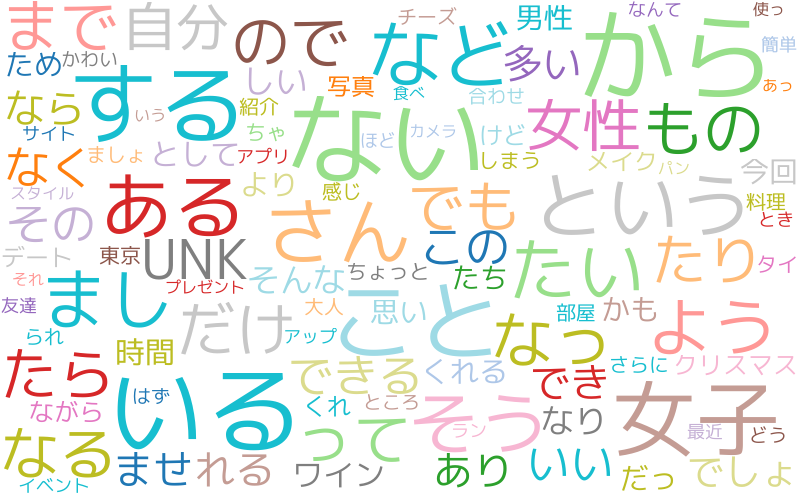

In [ ]:
npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    stopwords=stopwords,
)

In [ ]:
for text in rec_df.text[:10]:
    print(text)

NameError: ignored